In [266]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from math import sqrt, pi, exp
import scipy.linalg
import time
import matplotlib.pylab as pl
from scipy.sparse.linalg import eigs
import math
import functools
from eki_code.grad_inference import *

In [267]:

K     = np.diag([1,2]) # target e^{-1/2 u K^-1 u}
sqrtK = np.diag([1,sqrt(2)])#  % K^1/2
const = 1.81  # a user-specified const(>1) for the prefactor of convergence
N     = 200   # iteration number 
dt    = 0.05 # step size
d     = 2    # 2D 


In [268]:
# means and covariances along iterations
# for the optimal scheme
MM_opt = np.zeros((2,N))
CC_opt = np.zeros((2,2,N))


# distances to true mean and true covariance along iterations
dis_M_opt  = np.zeros((N,1)) 
dis_C_opt  = np.zeros((N,1))
dis_L2_opt = np.zeros((N,1))



In [227]:
"""
# means and covariances along iterations
# for our scheme
MM = np.zeros((2,N))
CC = np.zeros((2,2,N))
dis_M  = np.zeros((N,1)) 
dis_C  = np.zeros((N,1))
dis_L2 = np.zeros((N,1))
MM[:,0]   = m
CC[:,:,0] = C
"""

'\n# means and covariances along iterations\n# for our scheme\nMM = np.zeros((2,N))\nCC = np.zeros((2,2,N))\ndis_M  = np.zeros((N,1)) \ndis_C  = np.zeros((N,1))\ndis_L2 = np.zeros((N,1))\nMM[:,0]   = m\nCC[:,:,0] = C\n'

In [269]:
def construct_D_opt_tilde(C,d):
    eigenvalues, eigenvectors = np.linalg.eig(C)
    index_min = np.argmin(eigenvalues)
    lambda_min = eigenvalues[index_min]
    v = eigenvectors[:,index_min]
    #D_opt_tilde = (d/lambda_min)*np.tensordot(v,v,axes = 0) # D is symmetric 
    D_opt_tilde = (d/lambda_min)*np.dot(v,v.T)
    return D_opt_tilde, v, lambda_min

def construct_D_opt(C,d):
    D_opt_tilde, _ , lambda_min = construct_D_opt_tilde(C,d)
    D_opt = D_opt_tilde * lambda_min
    return D_opt


def construct_onb(d,v):
    psis = np.zeros((d,d))
    e_1, e_2 = np.eye(d)[:,0], np.eye(d)[:,1]
    
    xi = (1/np.sqrt(d))*(e_1+e_2)
    
    dot_product =  np.dot(v.T, xi) 
    theta =  math.acos(dot_product) 
    
    c, s = np.cos(theta), np.sin(theta)
    A_theta1 = np.array(((c, -s), (s, c))) 
    A_theta2 = np.array(((c, s), (-s, c)))

    if np.linalg.norm(np.dot(A_theta1,xi)-v)< 1e-8: # ici c'est reverse par rapport à Li
        A_theta = A_theta1
    elif np.linalg.norm(np.dot(A_theta2,xi)-v)< 1e-8:
        A_theta = A_theta2 
    else:
        print("error wrong angle computed")
    
    difference = xi - dot_product*v 
    v_prime = difference/np.linalg.norm(difference)
    v_processed = v[np.newaxis,:].T
    v_prime_processed = v_prime[np.newaxis,:].T
    V = np.concatenate((v_processed,v_prime_processed), axis = 1) 

    T = V.dot(A_theta).dot(V.T)
    
    # test 1
    print("test of Txi = v")
    print(np.all(np.isclose(np.dot(T,xi), v)))
    
    for i in range(0,d): # J'ai pas de "eta" comme dans le code de Li
        e_parallel = np.dot(np.eye(d)[:,i],xi)*xi +np.dot(np.eye(d)[:,i],v)*v
        e_orthogonal = np.eye(d)[:,i] - e_parallel
        psi = np.dot(T,e_parallel) + e_orthogonal # Difference : Li uses A instead of T
        psis[i]= psi
        
    # test 2
    print("test orthonormality of psis")
    print(np.all(np.isclose(np.dot(psis,psis.T), np.eye(d))))
    
    # test 3 
    for i in range(0,d):
        np.dot(v,psis[:,i])*np.dot(v,psis[:,i])
        
    return psis



def construct_J_opt_tilde(psis, v, lambda_min, c, d): # works for c>1 
    J_hat = np.zeros((d,d))

    lambda_1 = 1
    lambda_2 = c**2
    lambdas = [lambda_1, lambda_2] 
    
    for j in range(d):
        for k in range(j+1,2): # i also have an additional *(d/lamda_min) here compared to Li 
            J_hat[j,k] = ((lambdas[j]+lambdas[k])/(lambdas[j]-lambdas[k]))*np.dot(v,psis[:,j])*np.dot(v,psis[:,k])* (d/lambda_min)
            J_hat[k,j] = - J_hat[j,k]

    J_opt_tilde = functools.reduce(np.dot, [ psis, J_hat, psis.T])
    return J_opt_tilde

def construct_J_opt(psis, v, lambda_min, c, d, sqrtC):
    J_opt_tilde = construct_J_opt_tilde(psis, v, lambda_min, c, d)
    J_opt = functools.reduce(np.dot, [sqrtC, J_opt_tilde, sqrtC])
    return J_opt

In [270]:
print(psis[:,0])
print(psis[0])
print(psis)
print(np.eye(2))
print(np.eye(2)[:,0])

[ 0.91421356 -1.20710678]
[0.91421356 0.20710678]
[[ 0.91421356  0.20710678]
 [-1.20710678  0.5       ]]
[[1. 0.]
 [0. 1.]]
[1. 0.]


In [271]:
# for the optimal scheme D opt and J opt are computed from the target matrix covariance K

# initialization

m  = np.asarray([0.2,0.3]).T 
C  = np.diag([2,1])
MM_opt[:,0]   = m
CC_opt[:,:,0] = C

dis_M_opt[0] = np.linalg.norm(m)
dis_C_opt[0] = np.linalg.norm(C-K)

# construct D_opt and J_opt matrices
D_opt_tilde, v, lambda_min = construct_D_opt_tilde(K,d)
D_opt = construct_D_opt(K,d)

psis = construct_onb(d,v)
J_opt = construct_J_opt(psis, v, lambda_min, const, d, sqrtK) 
    
    
for iter in range(1,N):
    #print(iter)
    m = m - dt*np.dot((D_opt + J_opt),np.linalg.solve(K,m)) # li has a "d - j" below and has a multiplication by C in the end
    C   = C - dt*np.dot((D_opt + J_opt),np.linalg.solve(K,C)) \
                - dt*np.dot(C, np.linalg.solve(K,(D_opt+J_opt).T)) + 2*dt*D_opt
    MM_opt[:,iter]    = m
    CC_opt[:,:,iter]  = C
    #dis_L2[iter] = weighted_L2(m, C, [0,0]', K)
    dis_M_opt[iter] = np.linalg.norm(m)
    dis_C_opt[iter] = np.linalg.norm(C-K)

test of Txi = v
True
test orthonormality of psis
False


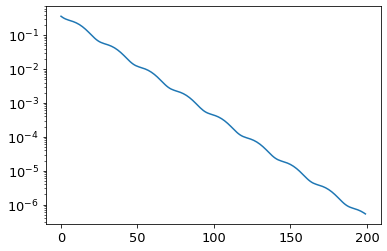

In [272]:
plt.yscale('log',base=10) 
plt.plot(range(0,N), dis_M_opt)

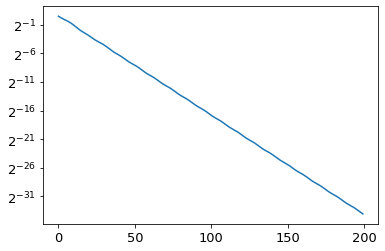

In [273]:
plt.yscale('log',base=2) 
plt.plot(range(0,N), dis_C_opt)

In [169]:
C  = np.diag([3,1])
D_opt_tilde, v, lambda_min = construct_D_opt_tilde(C, d)
D_opt = construct_D_opt(C,d)
lambda_min

psis = np.zeros((d,d))
e_1, e_2 = np.eye(d)[:,0], np.eye(d)[:,1]

xi = (1/np.sqrt(d))*(e_1+e_2)

dot_product =  np.dot(v.T, xi) 
theta =  math.acos(dot_product) 

c, s = np.cos(theta), np.sin(theta)
A_theta1 = np.array(((c, -s), (s, c))) 
A_theta2 = np.array(((c, s), (-s, c)))

if np.linalg.norm(np.dot(A_theta2,xi)-v)< 1e-8: # ici c'est reverse par rapport à Li
    A_theta = A_theta2
elif np.linalg.norm(np.dot(A_theta1,xi)-v)< 1e-8:
    A_theta = A_theta1
else:
    print("error wrong angle computed")
    print(np.dot(A_theta1,xi))
    print(np.dot(A_theta2,xi))
    print(v)

difference = xi - dot_product*v 
v_prime = difference/np.linalg.norm(difference)
v_processed = v[np.newaxis,:].T
v_prime_processed = v_prime[np.newaxis,:].T
V = np.concatenate((v_processed,v_prime_processed), axis = 1) 

T = V.dot(A_theta).dot(V.T)

# test
print("test du Txi = v")
print(not(np.all(np.isclose(np.dot(T,xi), v)))) 

for i in range(0,d): # J'ai pas de "eta" comme dans le code de Li
    e_parallel = np.dot(np.eye(d)[:,i],xi)*xi +np.dot(np.eye(d)[:,i],v)*v
    e_orthogonal = np.eye(d)[:,i] - e_parallel
    psi = np.dot(T,e_parallel) + e_orthogonal # Difference : Li uses A instead of T
    psis[:,i]= psi

test du Txi = v
True


In [170]:
# li elle a l'air d'utiliser cash dopt et jopt (pas les tilde)

for iter in range(0,N):
    print(iter)
    D_opt_tilde,v, lambda_min = construct_D_opt_tilde(C, d)
    D_opt = construct_D_opt(C,d)
    psis = construct_onb(d,v)
    J_opt = construct_J_opt(psis, v, lambda_min, c, d, sqrtK) 
    #J_opt = compute_J(v, const, sqrtK,  d, lambda);
    m = m - dt*np.dot((D_opt + J_opt),np.linalg.solve(K,m)) # li has a "d - j" below and has a multiplication by C in the end
    C   = C + dt*np.dot(-(D_opt + J_opt),np.linalg.solve(K,C)) - np.dot(C, np.linalg.solve(K,(D_opt+J_opt))) + 2*D_opt
    MM[:,iter]    = m
    CC[:,:,iter]  = C
    dis_M[iter] = np.linalg.norm(m)
    dis_C[iter] = np.linalg.norm(C-K)
    #dis_L2[iter] = weighted_L2(m, C, [0,0]', K)
end

0
test du Txi = v
True
1
error wrong angle computed
[-0.37513724  0.92696928]
[ 0.92696928 -0.37513724]
[ 0.78405345-0.j         -0.2322214 +0.57561568j]


/var/folders/_t/h78tns5s2990dvmw2d6kzfyw0000gn/T/ipykernel_2430/3905548168.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  theta =  math.acos(dot_product)


UnboundLocalError: local variable 'A_theta' referenced before assignment